In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
df1 = spark.read.format("csv").load("/content/CompleteDataset.csv",inferschema=True,header=True)
df1.show()

In [6]:
df1.rdd.getNumPartitions()

2

In [7]:
df2=df1.repartition(4)
df2.rdd.getNumPartitions()

4

In [ ]:
df2.show()

In [13]:
df2 =df2.withColumnRenamed("_c0","id")\
    .withColumnRenamed("Ball control","Ball_Control")\
    .withColumnRenamed("Sliding tackle","Sliding_Tackle")

df2.show(5)
# df2.na.fill({"RAM":10,"RB":1}).show()

+-----+---------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+-----+----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+----+----+----+----+----+------+----+----+----+----+----+----+----+----+----+----+-------------------+----+----+----+----+----+----+----+----+----+----+----+
|   ID|           Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|Value|Wage|Special|Acceleration|Aggression|Agility|Balance|Ball_Control|Composure|Crossing|Curve|Dribbling|Finishing|Free kick accuracy|GK diving|GK handling|GK

In [14]:
#transformation (select)
df2.select("Name","Overall").distinct().show(5)

+-------------+-------+
|         Name|Overall|
+-------------+-------+
|      J. John|     70|
|E. Latte Lath|     63|
|  A. Mercelán|     70|
|    A. Baluta|     65|
|      M. Díaz|     80|
+-------------+-------+
only showing top 5 rows



In [15]:
#filter
df2.filter(df2["Overall"]>70).show(10)

+----+---------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+------+-----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+----+----+----+----+----+------+----+----+----+----+----+----+----+----+----+----+-------------------+----+----+----+----+----+----+----+----+----+----+----+
|  ID|           Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo| Value| Wage|Special|Acceleration|Aggression|Agility|Balance|Ball_Control|Composure|Crossing|Curve|Dribbling|Finishing|Free kick accuracy|GK diving|GK handling|

In [16]:
df2.select("Overall","Name","Age").filter(df2["Overall"]>70).show(5)

+-------+-----------+---+
|Overall|       Name|Age|
+-------+-----------+---+
|     71| D. Cabrera| 27|
|     74|Enaldo Praz| 29|
|     81|M. Brozović| 24|
|     77| Juan Jesus| 26|
|     78|R. Karsdorp| 22|
+-------+-----------+---+
only showing top 5 rows



In [17]:
df2.where(df2["Overall"]>70).groupBy("Age").count().sort("Age").show(5)

+---+-----+
|Age|count|
+---+-----+
| 17|    1|
| 18|   13|
| 19|   41|
| 20|  105|
| 21|  160|
+---+-----+
only showing top 5 rows



<Axes: xlabel='Age'>

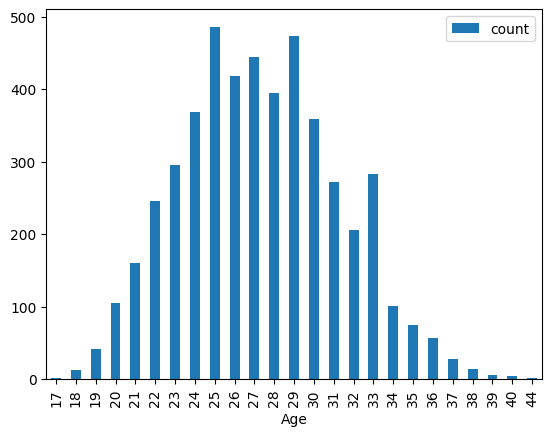

In [20]:
#visualize
df2_result = df2.where(df2["Overall"]>70).groupBy("Age").count().sort("Age")
pandas_df = df2_result.toPandas()
pandas_df.plot(x="Age",y="count",kind="bar")

In [21]:
# Spark SQL (register the DF using a local temporary view)

df2.createOrReplaceTempView("df_football")

In [23]:
# SQL query
sql_query = "SELECT Age,count(*) as Count FROM df_football WHERE Overall >70 GROUP BY Age ORDER BY Age"
result = spark.sql(sql_query)
result.show()

+---+-----+
|Age|Count|
+---+-----+
| 17|    1|
| 18|   13|
| 19|   41|
| 20|  105|
| 21|  160|
| 22|  246|
| 23|  296|
| 24|  369|
| 25|  486|
| 26|  418|
| 27|  444|
| 28|  395|
| 29|  474|
| 30|  359|
| 31|  272|
| 32|  206|
| 33|  283|
| 34|  101|
| 35|   74|
| 36|   57|
+---+-----+
only showing top 20 rows



In [24]:
# UDF

def uppercase_convert(record):
  if len(record)>10:
    return record.upper()
  else:
    return record.lower()

#register the DF
df2.createOrReplaceTempView("udf_football")

#register the function
spark.udf.register("UPPER",uppercase_convert)

#use the UDF in SQL
sql_query = "SELECT Age, UPPER(Name) as Name, UPPER(Club) as Club FROM UDF_Football"
result= spark.sql(sql_query)
result.show()

+---+----------------+--------------------+
|Age|            Name|                Club|
+---+----------------+--------------------+
| 19|    DOUGLAS LUIZ|           girona cf|
| 23|       a. schöpf|       FC SCHALKE 04|
| 27|      j. sánchez|         GUADALAJARA|
| 23|      y. barnawi|        AL QADISIYAH|
| 20|      c. colkett|             vitesse|
| 28|  J. HUYGHEBAERT|ROYAL EXCEL MOUSCRON|
| 34|        r. clark|      HOUSTON DYNAMO|
| 33|    JUNG JO GOOK|          gangwon fc|
| 27|    S. BENYAMINA|       HANSA ROSTOCK|
| 21|  HWANG HEE CHAN|FC RED BULL SALZBURG|
| 31|       s. dawson|                bury|
| 25|      a. budimir|             crotone|
| 31|        r. jérez|ASOCIACION DEPORT...|
| 27|         a. ligi|               carpi|
| 25|       j. chunga|CPD JUNIOR BARRAN...|
| 18|        a. maier|   HERTHA BSC BERLIN|
| 28|C. SCHÖSSWENDTER|  1. FC UNION BERLIN|
| 29|        m. azira|     COLORADO RAPIDS|
| 23|         mariano|  OLYMPIQUE LYONNAIS|
| 25|         h. pell|     CHELT